# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [117]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [118]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [119]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

fresh = critics.groupby('fresh')
freshcounts = fresh.critic.count()  # number of reviews by each critic

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))
print(critics.fresh.unique())
print(freshcounts)

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921
['fresh' 'rotten' 'none']
fresh
fresh     9015
none        22
rotten    5755
Name: critic, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15561 entries, 1 to 27616
Data columns (total 8 columns):
critic         14792 non-null object
fresh          15561 non-null bool
imdb           15561 non-null int64
publication    15561 non-null object
quote          15561 non-null object
review_date    15561 non-null object
rtid           15561 non-null int64
title          15561 non-null object
dtypes: bool(1), int64(2), object(5)
memory usage: 987.8+ KB
None
critic
A.D. Murphy           1.000000
A.H. Weiler           0.705882
A.O. Scott            0.368421
Aaron Hillis          1.000000
Abel Green            1.000000
                        ...   
Wesley Morris         0.333333
Whitney Willaims      0.750000
Whittaker Chambers    1.000000
William Brogdon       1.000000
William Goss          0.666667
Name: fresh, Length: 622, dtype: float64


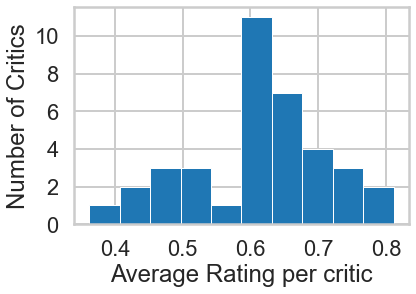

In [120]:
df = critics.copy()
# Turns all 'fresh' entries to True; 'rotten' to false
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # since True = 1, average freshness for each critic
print(df.info())
print(means)
# filter on critics with more than 100 reviews
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [121]:
print(df.fresh.value_counts())
df.head()

True     9482
False    6079
Name: fresh, dtype: int64


,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

Answer: The distribution would almost be normal except for the lack of values between .5 and .6;  this lack of values make the distribution appear bimodal with a smaller population of lower average rating of about .5 and a larger population of higher average ratings at about .6. So it appears that there are 2 different groups of critics that rate differently - a smaller group that are more critical and a larger group that are a bit more benevolent in their usage of 'fresh'. Because we are averaging, we do not see a distribution of averages down to 0 or up to 1, but converge towards the middle range.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [122]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [123]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [124]:
pd.DataFrame(X)

,0
0,"(0, 891)\t2\n (0, 1767)\t1\n (0, 2784)\t1\..."
1,"(0, 3835)\t1\n (0, 10463)\t1\n (0, 12878)\..."
2,"(0, 595)\t1\n (0, 939)\t1\n (0, 6758)\t1\n..."
3,"(0, 374)\t1\n (0, 891)\t1\n (0, 1049)\t1\n..."
4,"(0, 139)\t1\n (0, 757)\t1\n (0, 863)\t1\n ..."
...,...
15556,"(0, 855)\t1\n (0, 1591)\t1\n (0, 2093)\t1\..."
15557,"(0, 295)\t1\n (0, 6335)\t1\n (0, 7395)\t1\..."
15558,"(0, 282)\t1\n (0, 891)\t1\n (0, 1131)\t1\n..."
15559,"(0, 891)\t1\n (0, 3874)\t1\n (0, 3908)\t1\..."


In [125]:
# The organization of the X values in this sparse data format is 
#difficult to work with with the first value being ?? and the
#second value being the vectorized word for all words; make an interpretable x,y
#function instead by creating a dataframe with feature name:
def make_interpretable_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = pd.DataFrame(vectorizer.fit_transform(critics['quote']).toarray(), index = critics.index,
                           columns=vectorizer.get_feature_names())
    #X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X_2, y_2 = make_interpretable_xy(critics)


In [126]:
print(X_2.shape)
X_2.head()
# 22417 unique words found which are represented as columns
# index is the document (in this case a single review)

(15561, 22417)


,000,0014,007,044,07,10,100,101,102,104,105,108,10th,11,110,112,1138,114,118,11th,12,124,125,128,13,130,131,132,133,134,136,137,13th,14,141,145,15,153,15th,16,160,161,1660s,16mm,16th,17,17th,18,180,185,...,zellweger,zemeckis,zen,zero,zeroes,zest,zestfully,zesty,zeta,zhang,zhivago,ziggurats,zigs,zigzag,zigzags,zillion,zimmer,zing,zinger,zingers,zings,zingy,zinnemann,zinner,zip,zipper,zippo,zippy,zips,zirconium,zoe,zombie,zombies,zombified,zonca,zone,zoning,zoo,zoological,zoom,zooming,zooms,zorro,zorros,zowie,zucker,zweibel,zwick,zzzzzs,zzzzzzzzz
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [127]:
#your turn
#1 Splitting the data into training and test sets
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y, train_size=0.7)

In [128]:
#2 Using scikit-learn's MultinomialNB()
from sklearn.naive_bayes import MultinomialNB

In [129]:
#3 Training the classifier over the training set / test on the test set
clf = MultinomialNB().fit(xtrain, ytrain)

In [130]:
#4 Print the accuracy scores for both training and test sets
print("Training Accuracy Score: ",clf.score(xtrain,ytrain) * 100)
print("Test Accuracy Score: ",clf.score(xtest,ytest) * 100)

Training Accuracy Score:  92.2052882849798
Test Accuracy Score:  77.29706575283787


In [131]:
# Calculating the baseline also
baseline = np.bincount(y) / len(y)
print("{}% of the data is a 1.".format(100 * baseline[1]))

60.93438725017673% of the data is a 1.


Answers: With a testing accuracy of 77% and considering that the baseline accuracy (if we had a lazy classifier that predicted everything as 1) is 61%, we have definitely improved upon the baseline.  But we have not done any optimization of the hyperparameters which should improve the accuracy even further.

The very high training data score with respect to the testing data indicates that this method of classification may be overfitting the data.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

Text(0, 0.5, 'CDF')

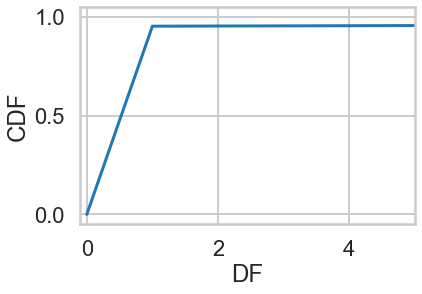

In [132]:
# Your turn.
# First Exercise: Cumulative distribution of doc freq
df = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))
rows, features = X.shape
height, axis = np.histogram(df, bins=len(np.unique(df)))
cumhist = np.cumsum(height * 1, axis=0) / features
axis = np.insert(axis, 0, 0)
cumhist = np.insert(cumhist, 0, 0)
plt.plot(axis[:-1], cumhist)
plt.xlim(-.1, 5)
plt.xlabel("DF")
plt.ylabel("CDF")

#Second Exercise: min_df and max_df estimation
Value chosen for min_df = 1; max_df = 75

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [133]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [134]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [135]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [136]:
pd.Series(mask).value_counts()

False    10892
True      4669
dtype: int64

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

Answer to Question 1: Log likelihood is a flavor of the maximum likelihood estimation (MLE) technique, which is a measure of probability or how likely we are to have observed the data.  Using log_likelihood serves to minimize the total error for all the residuals in the model. With the log of likelihood we want to aim for higher values.

Answer to Question 2: Higher alpha values would increase the amount of smoothing applied (by increasing the frequency probabilities or adding 'pseudocounts' for words that are not in our dictionary), which I would presume lead to less accurate probabilities and increases in the resulting false positive and false negative rates. 

In [137]:
# Answer to Question 3:
from sklearn.naive_bayes import MultinomialNB
    
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1
#best_min_df = None # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
scores = []
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn = Run MultinomialNB with selected alphas list
    clf = MultinomialNB(alpha=alpha)
    # Get log_liklehood score from each of the results
    cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    # Select maximum score and return the associated alpha (along with previous determination of best_min_df)
    if cvscore > maxscore:
        maxscore = cvscore
        best_alpha, best_min_df = alpha, best_min_df
    scores.append((alpha, cvscore))
scores

[(0.1, -946.6474400595391),
 (1, -730.8760525430173),
 (5, -1277.2377455938283),
 (10, -1425.5071799554928),
 (50, -1364.0342676487967)]

In [138]:
print("alpha: {}".format(best_alpha))

alpha: 1


In [142]:
# Using the cross validation technique from the Harvard solutions as a test and comparison of the above results:
#the grid of parameters to search over
alphas = [.01, .1, 1, 5, 10]
min_dfs = [.01, .1, 1, 2, 5]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df
            
print("alpha: %f" % best_alpha)
print("min_df: %f" % best_min_df)

alpha: 1.000000
min_df: 5.000000


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [143]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.913258
Accuracy on test data:     0.742012


In [144]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(xtest)
print(confusion_matrix(ytest, y_pred))

[[2694 1565]
 [1245 5388]]


In [148]:
# The following code indicates that the organization of the confusion matrix is: [TN FP/FN TP]
print(ytest.sum())
print(pd.Series(ytest).value_counts())
print(1245 + 5388)
print(clf.predict(xtest).sum())
print(pd.Series(clf.predict(xtest)).value_counts())
print(5388 + 1565)

6633
1    6633
0    4259
dtype: int64
6633
6953
1    6953
0    3939
dtype: int64
6953


Answer: I am not finding that the tuned model with optimal hyperparameters improves the test accuracy. 

The confusion matrix appears to be laid out in the following manner[TN FP/FN TP]. The model does well to predict the true positives with a high number of 5388 compared to the total of 6633.  However the high number of both alse positives and negatives is disconcerting. This means the model will predict actual negative reviews as positive reviews (like the following exercise below) and vice versa.

One thing that I noticed is that using different methods of tuning the hyperparameters will result in different results here.  For example, using min_df of 1 and alpha of 1 produces a confusion matrix that tends to be overly optimistic in its predictions of positive reviews.  The use of min_df of 5 and alpha of 1 produces a more 'balanced' confusion matrix with an equal proportion of both false positives and false negatives.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [149]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)
print(x)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Good words	     P(fresh | word)
         intelligent 0.97
             delight 0.95
            dazzling 0.95
            funniest 0.94
           absorbing 0.94
          remarkable 0.94
              moving 0.93
         masterpiece 0.93
         beautifully 0.93
              richly 0.93
Bad words	     P(fresh | word)
           blandness 0.13
                poor 0.13
                five 0.13
               fault 0.12
           pointless 0.12
             muddled 0.12
             trouble 0.12
             unfunny 0.10
                dull 0.09
                lame 0.08


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Answer: It works because it represents the probability that the given word is associated with a positive rating. Bayes rule makes it easy to compute and interpret.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [150]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

This is precisely the type of moviegoing experience engineered for those who still get a laugh when the Baha Men hit Who Let the Dogs Out? accompanies a doggie mayhem montage.

Drew Barrymore movies have an advantage that others don't -- they have Drew Barrymore in them. But that doesn't take away from the fact that she makes more lousy pictures than any other good actress.

In his Hollywood debut, Shaq more or less played himself as a coveted college center in William Friedkin's excellent Blue Chips. Kazaam is a compelling argument for keeping him on the court and as far away from a movie set as possible.

An ambitious, serious but not particularly stimulating musical feature that unconvincingly attempts to graft warm and cuddly fa

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [151]:
#your turn
Xquery = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])

clf.predict_proba(Xquery)


array([[0.0079434, 0.9920566]])

Answer: First to interpret the output - the rightmost value is the probability that the review is positive, which is very high.  The results do not surprise me, since we are using a bag or words algorithm where the words 'remarkable', 'touching', and 'superb' would have a high probability of being positive 'fresh'.  The algorithm does not take into contextual factors, such as the fact that these adjectives are prefaced with 'not' and followed by 'in any way'.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [152]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [153]:
# 1 Rerun model using n-grams parameter
# a Vectorize using CountVectorizer again, but including ngram_range parameter 
def make_xy_ngram(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
Xngram, yngram = make_xy_ngram(critics)

#b split into test and training sets
xngramtrain, xngramtest, yngramtrain, yngramtest = train_test_split(Xngram,yngram, train_size=0.7)

#c Train the classifier over the training set / test on the test set / using MultinomialNB again
ngram = MultinomialNB().fit(xngramtrain, yngramtrain)

#d Print the accuracy scores for both training and test sets
print("Training Accuracy Score: ",ngram.score(xngramtrain, yngramtrain) * 100)
print("Test Accuracy Score: ",ngram.score(xngramtest,yngramtest) * 100)

Training Accuracy Score:  99.08189496878444
Test Accuracy Score:  76.14050117798243


In [183]:
# Model has overfit but test accuracy is already higher than the initial model; need to optimize hyperparams again

# Using the cross validation technique from the Harvard solutions as it produced better results above:

from sklearn.model_selection import KFold
def cv_score(ngram, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        ngram.fit(X[train], y[train]) # fit the classifier, passed is as ngram.
        result += scorefunc(ngram, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

#3 Scoring function again
def log_likelihood_ngram(ngram, x, y):
    prob = ngram.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

#4 Set up test masks - not needed - already set up
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

#the grid of parameters to search over
alphas_ngram = [.01, .1, 1, 5, 10]
min_dfs_ngram = [.01, .1, 1, 2, 5]

#Find the best value for alpha and min_df, and the best classifier
best_alpha_ngram = None
best_min_df_ngram = None
maxscore=-np.inf
for alpha in alphas_ngram:
    for min_df in min_dfs_ngram:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy_ngram(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha_ngram, best_min_df_ngram = alpha, min_df
            
print("alpha: %f" % best_alpha_ngram)
print("min_df: %f" % best_min_df_ngram)

alpha: 1.000000
min_df: 5.000000


In [184]:
# Rerun model with optimzed parameters

# a Vectorize using CountVectorizer again, but including ngram_range parameter 
def make_xy_ngram(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df = 5, ngram_range=(1,2))
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
Xngram, yngram = make_xy_ngram(critics)

#b split into test and training sets
xngramtrain, xngramtest, yngramtrain, yngramtest = train_test_split(Xngram,yngram, train_size=0.7)

#c Train the classifier over the training set / test on the test set / using MultinomialNB again
ngram = MultinomialNB(alpha=1).fit(xngramtrain, yngramtrain)

#Print the accuracy scores for both training and test sets
print("Training Accuracy Score: ",ngram.score(xngramtrain, yngramtrain) * 100)
print("Test Accuracy Score: ",ngram.score(xngramtest,yngramtest) * 100)

Training Accuracy Score:  89.39588688946016
Test Accuracy Score:  76.50460484043693


In [186]:
# 5
#a Vectorize using Tfidf
def make_xy_tfidf(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
Xtfidf, ytfidf = make_xy_tfidf(critics)

#b split into test and training sets
xtfidftrain, xtfidftest, ytfidftrain, ytfidftest = train_test_split(Xtfidf,ytfidf, train_size=0.7)

#c Train the classifier over the training set / test on the test set / using MultinomialNB again
tfidft = MultinomialNB().fit(xtfidftrain, ytfidftrain)

#d Print the accuracy scores for both training and test sets
print("Training Accuracy Score: ",tfidft.score(xtfidftrain,ytfidftrain) * 100)
print("Test Accuracy Score: ",tfidft.score(xtfidftest,ytfidftest) * 100)

Training Accuracy Score:  84.74109438119721
Test Accuracy Score:  72.4352109659456


In [187]:
# Model has overfit and test accuracy is lower than initial model; need to optimize hyperparams again

# Using the cross validation technique from the Harvard solutions as it produced better results above:

from sklearn.model_selection import KFold
def cv_score_tfidft(tfidft, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        tfidft.fit(X[train], y[train]) # fit the classifier, passed is as tfidft.
        result += scorefunc(tfidft, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

#3 Scoring function again
def log_likelihood_tfidft(tfidft, x, y):
    prob = tfidft.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

#4 Set up test masks - not needed - already set up
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

#the grid of parameters to search over
alphas_tfidf = [.01, .1, 1, 5, 10]
min_dfs_tfidf = [.01, .1, 1, 2, 5]

#Find the best value for alpha and min_df, and the best classifier
best_alpha_tfidf = None
best_min_df_tfidf = None
maxscore=-np.inf
for alpha in alphas_tfidf:
    for min_df in min_dfs_tfidf:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy_tfidf(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha_tfidf, best_min_df_tfidf = alpha, min_df
            
print("alpha: %f" % best_alpha_tfidf)
print("min_df: %f" % best_min_df_tfidf)

alpha: 1.000000
min_df: 5.000000


In [189]:
# Rerun model with optimzed parameters

#a Vectorize using Tfidf
def make_xy_tfidf(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = TfidfVectorizer(min_df = 5, stop_words='english')
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
Xtfidf, ytfidf = make_xy_tfidf(critics)

#b split into test and training sets
xtfidftrain, xtfidftest, ytfidftrain, ytfidftest = train_test_split(Xtfidf,ytfidf, train_size=0.7)

#c Train the classifier over the training set / test on the test set / using MultinomialNB again
tfidft = MultinomialNB(alpha = 1).fit(xtfidftrain, ytfidftrain)

#d Print the accuracy scores for both training and test sets
print("Training Accuracy Score: ",tfidft.score(xtfidftrain,ytfidftrain) * 100)
print("Test Accuracy Score: ",tfidft.score(xtfidftest,ytfidftest) * 100)

Training Accuracy Score:  84.05251560778552
Test Accuracy Score:  74.91968301563504


I tried the ngram approach using 2 word n grams and the tfidf approach.  In both attempts I ran a default model, then did some cross validation as above to determine the optimum hyperparameters.  None of these performed as accurately as the out of the box default countvectorizer model, even the ones with optimized hyperparameters (best min_df and best alpha did not change at all). 